# Craiglist Housing Detail Analysis

In this notebook I will be exploring the listings from Craigslist in a geospatial context to see what insights or patterns can be seen. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point


# Loading in Spatial Analytics Shape File

After loading in the shape file, the columns designated VALUE# based on the documentaation provided. The null polygons are then removed to prevent possible errors in the code.

AxesSubplot(0.235366,0.125;0.554268x0.755)


,spatial_id,name,Total Households,Total Population,Median Household Income,geometry
0,5350001.00,"CT0001.00, Toronto, ON",249.0,600.0,79727.91,"POLYGON ((-79.30312052680827 43.6557792424362,..."
1,5350002.00,"CT0002.00, Toronto, ON",267.0,613.0,74505.79,POLYGON ((-79.34874705621597 43.63005940385361...
2,5350003.00,"CT0003.00, Toronto, ON",537.0,1557.0,88073.28,POLYGON ((-79.43442817686808 43.63362770070954...
3,5350004.00,"CT0004.00, Toronto, ON",3712.0,7177.0,27670.45,POLYGON ((-79.43602519603924 43.63716951121133...
4,5350005.00,"CT0005.00, Toronto, ON",3722.0,6969.0,33807.26,POLYGON ((-79.42457648823653 43.64104908625342...


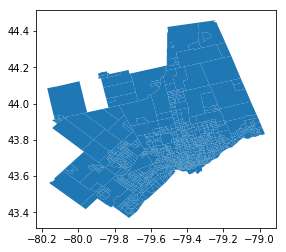

In [4]:
#import shapefile from Spatial Analytics
map_df = gpd.read_file("SA_shapefile.shp")
#Column labels taken from documentation provided with shapefile.
map_df.rename(columns={'VALUE0':'Total Households'}, inplace=True)
map_df.rename(columns={'VALUE1':'Total Population'}, inplace=True)
map_df.rename(columns={'VALUE2':'Median Household Income'}, inplace=True)
print(map_df.plot())
map_df.head()

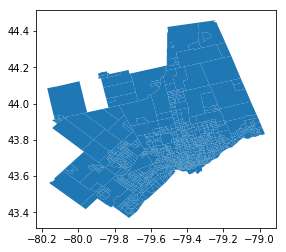

In [62]:
#remove null geometry from shapefile_SA
map_df = map_df[pd.notnull(map_df['geometry'])]
map_df.plot()

When querying the crs value for the Spatial Analytics shapefile, no results was returned. Therefore, I opted to use the standard EPSG:4326 WSG84 geographic coordinate system.

In [63]:
crs = {'init': 'epsg:4326'}
map_df = gpd.GeoDataFrame(map_df, crs=crs,geometry='geometry')
map_df.crs

{'init': 'epsg:4326'}

# Import Cleaned CL dataframe

In [64]:
#import cleaned dataframe from Craiglist Housing
#df = pd.read_csv("craigslist_housing_cleaned.csv")
df = pd.read_csv("craigslist_housing_cleaned.csv", encoding = "ISO-8859-1")
df.head()

,id,area,bedrooms,date,price,latitude,longitude,neighbourhood,text,outlier,ppbed,pparea
0,6812910773,2100.0,4.0,2019-03-07,659000.0,43.188546,-79.836381,hamilton,STONEY CREEEK- PRE CONSTRUCTION DETAC,False,164750.0,313.809524
1,6812921890,950.0,2.0,2019-03-07,579000.0,43.569182,-79.567237,mississauga,MISSISSAUGA LAKESHORE RD - UPSCALE URBAN TOWN...,False,289500.0,609.473684
2,6812934716,500.0,1.0,2019-03-07,465000.0,43.626406,-79.480574,etobicoke,TORONTO- LAKEFRONT LUXURY CONDOS FR,False,465000.0,930.000000
3,6813641313,1625.0,3.0,2019-03-07,471000.0,43.351751,-80.327754,cambridge,CAMBRIDGE- PRE-CONSTRUCTION FREEHOLD TOWNHOME...,False,157000.0,289.846154
4,6813651847,525.0,1.0,2019-03-07,437000.0,43.589177,-79.646570,mississauga,MISSISSAUGA- PRE-CONSTRUCTION,False,437000.0,832.380952


A little feature engineering...

I tried to use a really simple calcuation to find an annual mortgage payment with compounding interest. This will be use later on in my calulation of affordability metrics. I have separated the inputs so that these mortgage interest rate and duration of the mortgage in months can be changed.

The 4% interest rate is the median mortgage rate being offered in Toronto, Canada as at May 1st, 2019. The rates included are both permium (VIP) banking rates, the employee internal rates and standard external rates. 

The duration (months) is for a 25 year mortgage. Standard for the gen xy population.

Note: for simplicity the calculation is for 1 year and does not account for decrease in principal. When projecting into the future be careful not go beyong 5 years as this the standard period for re-mortgage and the rate will most likely change. 

In [65]:
#Enter new value to recalculate mortgage payments. 
mortgage_rate = 4 #Mortgage interest rate (%) - don't include %
months = 300 #Mortgage duration in Months (years x 12)

In [66]:
#compounded total interest rate
cmpd_total_int = (1+(mortgage_rate/1200))**months
#Annual principal multiplier
p_multiplier = ((mortgage_rate/1200)*cmpd_total_int)/(cmpd_total_int-1)*12


In [67]:
df['mortgage principal'] = (df['price']*0.8)
df['deposit'] = df['price']*0.2
df['annual mortgage payment']=df['mortgage principal']*p_multiplier
df

,id,area,bedrooms,date,price,latitude,longitude,neighbourhood,text,outlier,ppbed,pparea,mortgage principal,deposit,annual mortgage payment
0,6812910773,2100.0,4.0,2019-03-07,659000.0,43.188546,-79.836381,hamilton,STONEY CREEEK- PRE CONSTRUCTION DETAC,False,164750.000000,313.809524,527200.0,131800.0,33393.069865
1,6812921890,950.0,2.0,2019-03-07,579000.0,43.569182,-79.567237,mississauga,MISSISSAUGA LAKESHORE RD - UPSCALE URBAN TOWN...,False,289500.000000,609.473684,463200.0,115800.0,29339.282931
2,6812934716,500.0,1.0,2019-03-07,465000.0,43.626406,-79.480574,etobicoke,TORONTO- LAKEFRONT LUXURY CONDOS FR,False,465000.000000,930.000000,372000.0,93000.0,23562.636551
3,6813641313,1625.0,3.0,2019-03-07,471000.0,43.351751,-80.327754,cambridge,CAMBRIDGE- PRE-CONSTRUCTION FREEHOLD TOWNHOME...,False,157000.000000,289.846154,376800.0,94200.0,23866.670571
4,6813651847,525.0,1.0,2019-03-07,437000.0,43.589177,-79.646570,mississauga,MISSISSAUGA- PRE-CONSTRUCTION,False,437000.000000,832.380952,349600.0,87400.0,22143.811124
5,6816555663,1838.0,3.0,2019-03-10,275000.0,43.655500,-79.362600,toronto,PGA Village Resort - Sunny Fla - Guard Gated G...,False,91666.666667,149.619151,220000.0,55000.0,13934.892584
6,6817953944,2100.0,4.0,2019-03-07,659000.0,43.188546,-79.836381,hamilton,STONEY CREEEK- PRE CONSTRUCTION DETACHED HOMES...,False,164750.000000,313.809524,527200.0,131800.0,33393.069865
7,6817962523,950.0,2.0,2019-03-07,579000.0,43.569182,-79.567237,mississauga,MISSISSAUGA LAKESHORE RD - UPSCALE URBAN TO,False,289500.000000,609.473684,463200.0,115800.0,29339.282931
8,6817971069,500.0,1.0,2019-03-07,465000.0,43.626406,-79.480574,etobicoke,TORONTO- LAKEFRONT LUXURY CONDOS FROM400s,False,465000.000000,930.000000,372000.0,93000.0,23562.636551
9,6818055407,525.0,1.0,2019-03-07,437000.0,43.589177,-79.646570,mississauga,MISSISSAUGA- PRE-CONSTRUCTION CONDOS FOR SALE...,False,437000.000000,832.380952,349600.0,87400.0,22143.811124


Create geodataframe from cleaned data and set crs to match shapefile.

In [68]:
#Format Lat/lon correctly for plotting
df['coordinates']=list(zip(df.longitude, df.latitude))
df['coordinates'] = df['coordinates'].apply(Point)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(df, crs=crs,geometry='coordinates')
gdf.head()

,id,area,bedrooms,date,price,latitude,longitude,neighbourhood,text,outlier,ppbed,pparea,mortgage principal,deposit,annual mortgage payment,coordinates
0,6812910773,2100.0,4.0,2019-03-07,659000.0,43.188546,-79.836381,hamilton,STONEY CREEEK- PRE CONSTRUCTION DETAC,False,164750.0,313.809524,527200.0,131800.0,33393.069865,POINT (-79.836381 43.188546)
1,6812921890,950.0,2.0,2019-03-07,579000.0,43.569182,-79.567237,mississauga,MISSISSAUGA LAKESHORE RD - UPSCALE URBAN TOWN...,False,289500.0,609.473684,463200.0,115800.0,29339.282931,POINT (-79.56723700000001 43.569182)
2,6812934716,500.0,1.0,2019-03-07,465000.0,43.626406,-79.480574,etobicoke,TORONTO- LAKEFRONT LUXURY CONDOS FR,False,465000.0,930.000000,372000.0,93000.0,23562.636551,POINT (-79.480574 43.626406)
3,6813641313,1625.0,3.0,2019-03-07,471000.0,43.351751,-80.327754,cambridge,CAMBRIDGE- PRE-CONSTRUCTION FREEHOLD TOWNHOME...,False,157000.0,289.846154,376800.0,94200.0,23866.670571,POINT (-80.327754 43.351751)
4,6813651847,525.0,1.0,2019-03-07,437000.0,43.589177,-79.646570,mississauga,MISSISSAUGA- PRE-CONSTRUCTION,False,437000.0,832.380952,349600.0,87400.0,22143.811124,POINT (-79.64657 43.589177)


# Creating Combined Geodataframe for Analysis

We can now create a combined geodataframe using the cleaned data and our SA shapefile data.

In [69]:
#combine SA Shapefile and cleaned data
pointInPoly = gpd.sjoin(gdf, map_df, op='within') 

With the two geodataframes merged, we can now calculate the affordability metrics by comparing the annual mortgage payment and deposit against the median household income.

In [70]:
#Calculate Affordability Metrics
pointInPoly['affordability_mort']=pointInPoly['annual mortgage payment']-pointInPoly['Median Household Income']
pointInPoly['affordability_dep']=pointInPoly['deposit']-(pointInPoly['Median Household Income']*0.4*5)

Scoring function breakdown

Penalizes the affordability metrics.

    Affordability_Mort: Annual Mortgage Payments
    Positive value is the dollar amount in which annual mortgage payment exceed a household's income
    Negative values is the dollar amount in which household's income exceeds the annual mortgage payment for a listing.
    
    Affordability_Dep: Deposit
    Positive value is the dollar amount in which a listings deposit exceeds a households savings over 5 years with a savings rate of 40% of annual income. A negative amount denotes the opposite.
  
    Bedrooms and area are both increase the scores. 
    
    Price/Income metrics are captured in Affordability
    

In [71]:
#test set score
def set_scores(row):
    score = ((row['bedrooms']*1)+
             (row['area']*1.5)+
             (row['affordability_mort']*-1.5)+
             (row['affordability_dep']*-1.5)
            )
    return score

Apply the function for all rows starting at axis 1

In [72]:
pointInPoly['score'] = pointInPoly.apply(set_scores, axis=1)

With all the metrics calculated, we cna now aggregate the data by neighbourhood(polygon) in the geodataframe.


In [73]:
#aggregate overall data by neighborhood
tmp_ppbed = pointInPoly.groupby('name')['ppbed'].median()
tmp_pparea = pointInPoly.groupby('name')['pparea'].median()
tmp_bedrooms= pointInPoly.groupby('name')['bedrooms'].mean()
tmp_price= pointInPoly.groupby('name')['price'].median()
tmp_area= pointInPoly.groupby('name')['area'].median()
tmp_score= pointInPoly.groupby('name')['score'].mean()
tmp_mort= pointInPoly.groupby('name')['annual mortgage payment'].median()
tmp_afm= pointInPoly.groupby('name')['affordability_mort'].mean()
tmp_afd= pointInPoly.groupby('name')['affordability_dep'].mean()
tmp_deposit= pointInPoly.groupby('name')['deposit'].median()

#join to shapefile
map_df_tmpa=map_df.merge(tmp_ppbed, on='name')
map_df_tmpa=map_df_tmpa.merge(tmp_pparea, on='name')
map_df_tmpa=map_df_tmpa.merge(tmp_bedrooms, on='name')
map_df_tmpa=map_df_tmpa.merge(tmp_price, on='name')
map_df_tmpa=map_df_tmpa.merge(tmp_area, on='name')
map_df_tmpa=map_df_tmpa.merge(tmp_score, on='name')
map_df_tmpa=map_df_tmpa.merge(tmp_afm, on='name')
map_df_tmpa=map_df_tmpa.merge(tmp_afd, on='name')
map_df_tmpa=map_df_tmpa.merge(tmp_mort, on='name')
map_df_tmpa=map_df_tmpa.merge(tmp_deposit, on='name')

#Store in map_df2
map_df2 = map_df_tmpa

#fill NA with 0's
map_df2['ppbed'].fillna(0, inplace=True)
map_df2['pparea'].fillna(0, inplace=True)
map_df2['area'].fillna(0, inplace=True)
map_df2['bedrooms'].fillna(0, inplace=True)
map_df2['price'].fillna(0, inplace=True)
map_df2['score'].fillna(0, inplace=True)
map_df2['affordability_mort'].fillna(0, inplace=True)
map_df2['affordability_dep'].fillna(0, inplace=True)
map_df2['annual mortgage payment'].fillna(0, inplace=True)
map_df2['deposit'].fillna(0, inplace=True)
map_df2.crs = map_df.crs

Finally we convert the CRS to EPSG:2019 which is the projected coordinate system for Canada - Ontario - between 81°W and 78°W: south of 46°N

In [74]:
print(map_df2.crs)
map_df2 = gpd.GeoDataFrame(map_df2, crs=crs,geometry='geometry')
map_df2 = map_df2.to_crs({'init':'epsg:2019'})
map_df2.crs
gdf['coordinates']=gdf['coordinates'].to_crs(epsg=2019)

{'init': 'epsg:4326'}


In [75]:
#Rotate map to be better visually represented
map_df2['geometry']=map_df2['geometry'].rotate(angle = -17, origin=(315000,4840000), use_radians=False)
gdf['coordinates']=gdf['coordinates'].rotate(angle = -17, origin=(315000,4840000), use_radians=False)

# Data Vizualization and Analysis

define x-y coordinates using latitutde and longitude

In [76]:
gdf['longitude'] = gdf.coordinates.x
gdf['latitude'] = gdf.coordinates.y

Plotting all listing we can see a good clustering with a few outliers. This means that we were able to eliminate a majority of the foreign investment listings during our data cleaning phase. Since our focus in on Toronto, we will apply coordinate limit filters to define our coordinate.

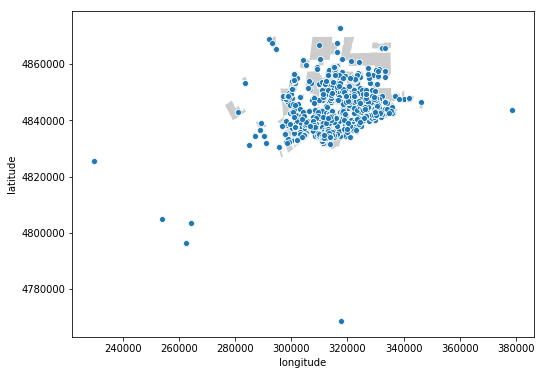

In [77]:
#plot all listings
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
map_df2.plot(ax=ax, color='gray',alpha = 0.4,)
sns.scatterplot("longitude", "latitude", data=gdf)
plt.show()

We will apply the below coordinate limits based on the above chart.

In [78]:
xlim = (292500,340000)
ylim = (4828000,4855000)

# Plotting all Listings by Neighbourhood

From plotting on listings on a map, two clustering trends become very apparent:

    1) heavy clustering around the Downtown core, specifically neighbourhoods ("N")...
        N77: Waterfront
        N70: South Riverside
        N75: Church-Yonge
        N76 Bay Street
        N81: Trinity Bellwoods
        N82: Niagara North (liberty village)
    2) Surprisingly, there was a disinct narrow corridor of clustering at at N51: Willowdale which was crowned in 2015 by the Toronto Star as the hottest up and coming neighbourhood in Toronto.

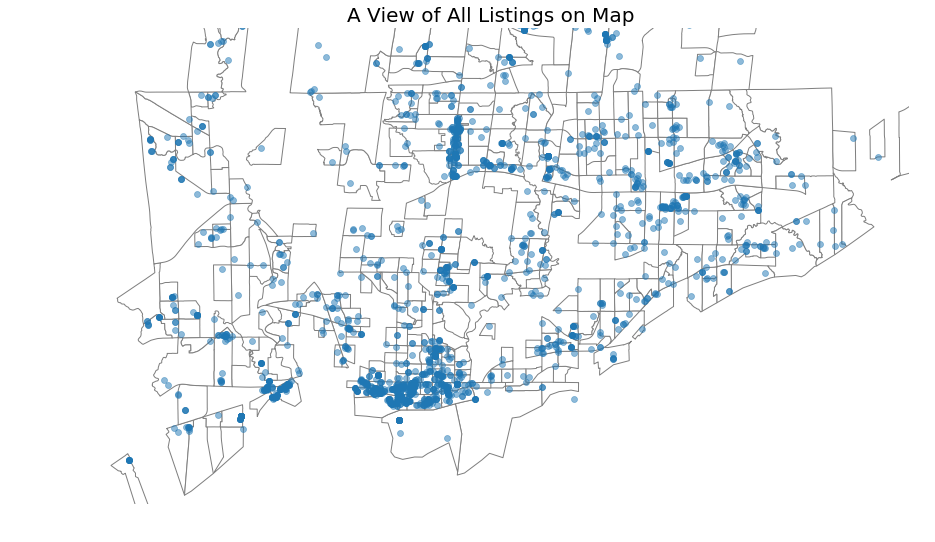

In [79]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
map_df2.plot(ax=ax, color='white',edgecolor = 'grey')
sns.scatterplot("longitude", "latitude", data=gdf,edgecolor = None ,alpha = 0.5)
plt.title('A View of All Listings on Map',fontsize=20)
plt.xlim(xlim)
plt.ylim(ylim)
ax.axis('off')
plt.show()

# Average Number of Bedrooms By Neighbourhood

Confirming expectations, the heavy cluster located in the Downtown core/Waterfront regions are predominiately 1 - 2 bedroom units and most likely condos. As you move over to South Riverdale region though we can see the bedroom sizes increase, perhaps indicateing townhouse complexes. The Willowdale East cluster seems to me made up of 1 - 2 bedrooms as well. On interesting observation is South-East Yorkdale-Glen Park seems to have very large 7-8 bedrooms units. We'll see if the median household income of this neighbourhood reflects the house size in the following maps.


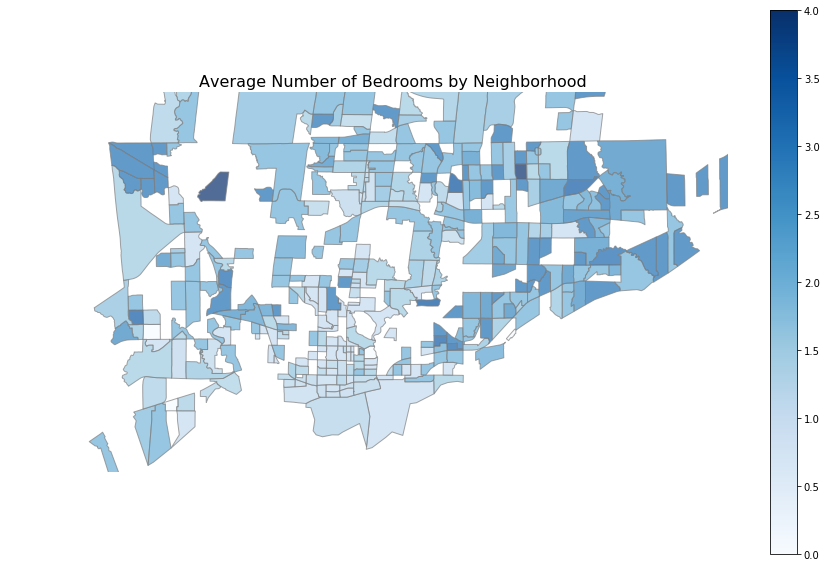

In [53]:
#Plot average number of bedrooms
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
map_df2.plot(ax=ax, column = 'bedrooms',edgecolor = 'grey',alpha = 0.7,cmap='Blues',legend=True)
plt.xlim(xlim)
plt.ylim(ylim)
plt.title('Average Number of Bedrooms by Neighborhood',fontsize=16)
ax.axis('off')
plt.show()

# Average Realestate Prices by Neighbourhood

One obervation that immediately pops out is the extremely high house price in N9:Edenbridge-Humber Valley (only dark red region). Upon further research, Edenbridge-Humber valley is one of the wealthiest in Toronto. It is a suburban neighbourhood developed for wealthy people. In contrast to the surronding neighbourhoods like N115:Mount Dennis which was an industrial, working-class neighbourhood some distance from the centre of the city because of factories, industry and slaughter houses.

Looking at Downtown core we can see that the price is relatively lower. Lower being the $0 - $1.5MM range but that makes sense due to the density of condo development.


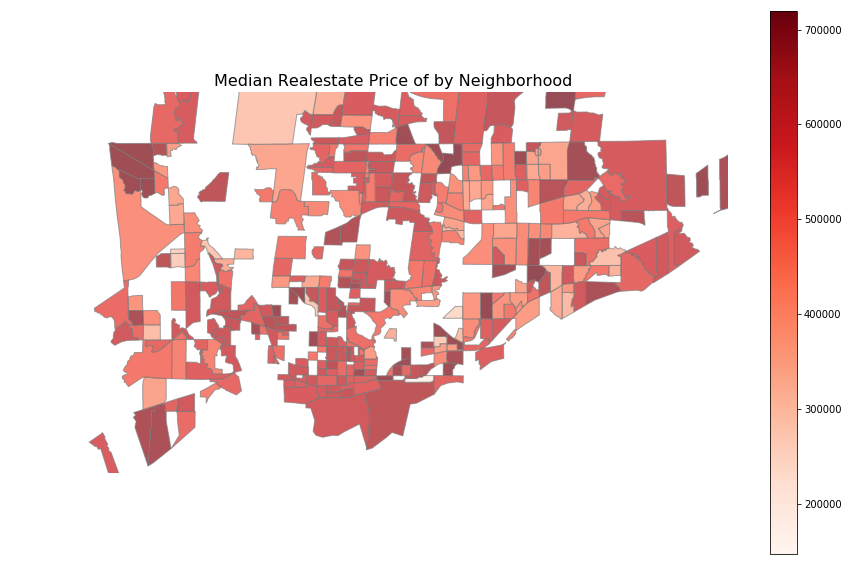

In [54]:
#Plot price
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
map_df2.plot(ax=ax, column = 'price',edgecolor = 'grey',alpha = 0.7,cmap='Reds',legend=True)
plt.xlim(xlim)
plt.ylim(ylim)
#plt.xlim(307500,317500)
#plt.ylim(4830000,4840000)
plt.title('Median Realestate Price of by Neighborhood',fontsize=16)
ax.axis('off')
plt.show()

# Average Median Household Income by Neighbourhood

Looking at average median household income, it is no surprise that the N41: Bridle Path-Sunnybrook-York Mills neighbourhood is the highest. While it's a little odd that the house prices in this neighbourhood were relatively low, when compared to income; however, this data came from craiglist, which may not be the go to source of realestate listing for these areas. Another observation is that the observed income of residents in the downtown core is relatively low, somewhere between ($) 50,000 to 100,000.

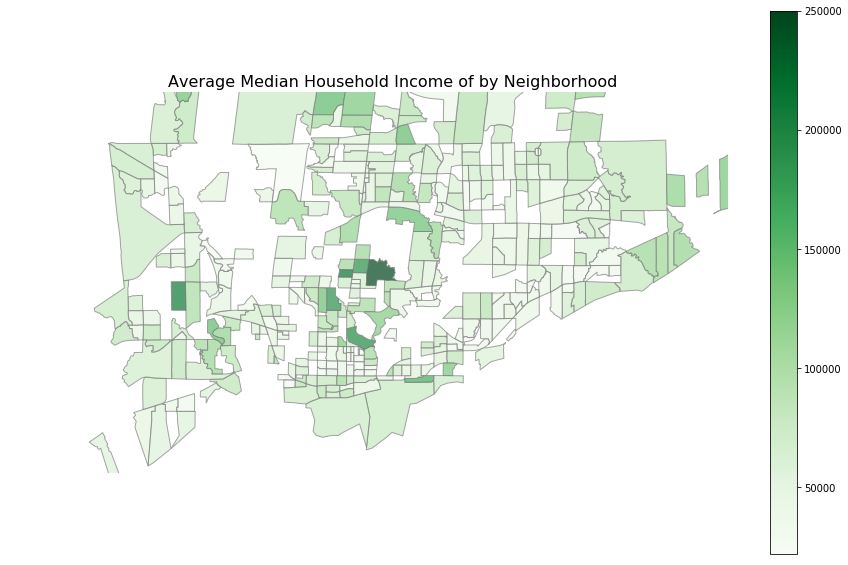

In [55]:
#Median Household Income
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
map_df2.plot(ax=ax, column = 'Median Household Income',edgecolor = 'grey',alpha = 0.7,cmap='Greens',legend=True)
plt.xlim(xlim)
plt.ylim(ylim)
#plt.xlim(307500,317500)
#plt.ylim(4830000,4840000)
plt.title('Average Median Household Income of by Neighborhood',fontsize=16)
ax.axis('off')
plt.show()

# Listings Overlayed on Average Median Household Income by Neighbourhood

Viewing the listings overlayed on the median income show a high demand for realestate in the core despite the the lower end incomes. This could also explain why the housing prices are relatively low (under $1MM). Next we will examine the affordability of housing in Toronto based on income.

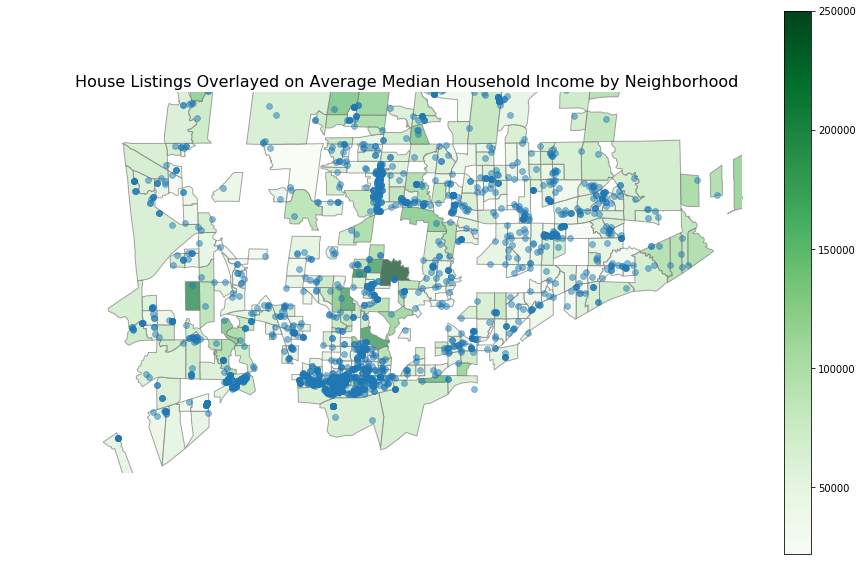

In [56]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
map_df2.plot(ax=ax, column = 'Median Household Income',edgecolor = 'grey',alpha = 0.7,cmap='Greens',legend=True)
sns.scatterplot("longitude", "latitude", data=gdf,edgecolor = None ,alpha = 0.5)
plt.xlim(xlim)
plt.ylim(ylim)
plt.title('House Listings Overlayed on Average Median Household Income by Neighborhood',fontsize=16)
ax.axis('off')
plt.show()

# Mortgage Affordability of Listing by Neighbourhood based on Median Income

Based on the criteria set for affordability (i.e. Annual Mortgage Payments less than Annual Household Income, and house deposit less than 5 years worth of savings at 40%), we can see that housing, especially in the downtown core cluster, is relatively affordable. That being said, we know that the core is pre-dominately 1-2 bedroom units. The areas that tend to have more bedrooms are significantly unaffordable for the median household incomes in the neighbourhood.


Text(0.5, 1.0, 'Mortgage Deposit Affordability by Neighbourhood')

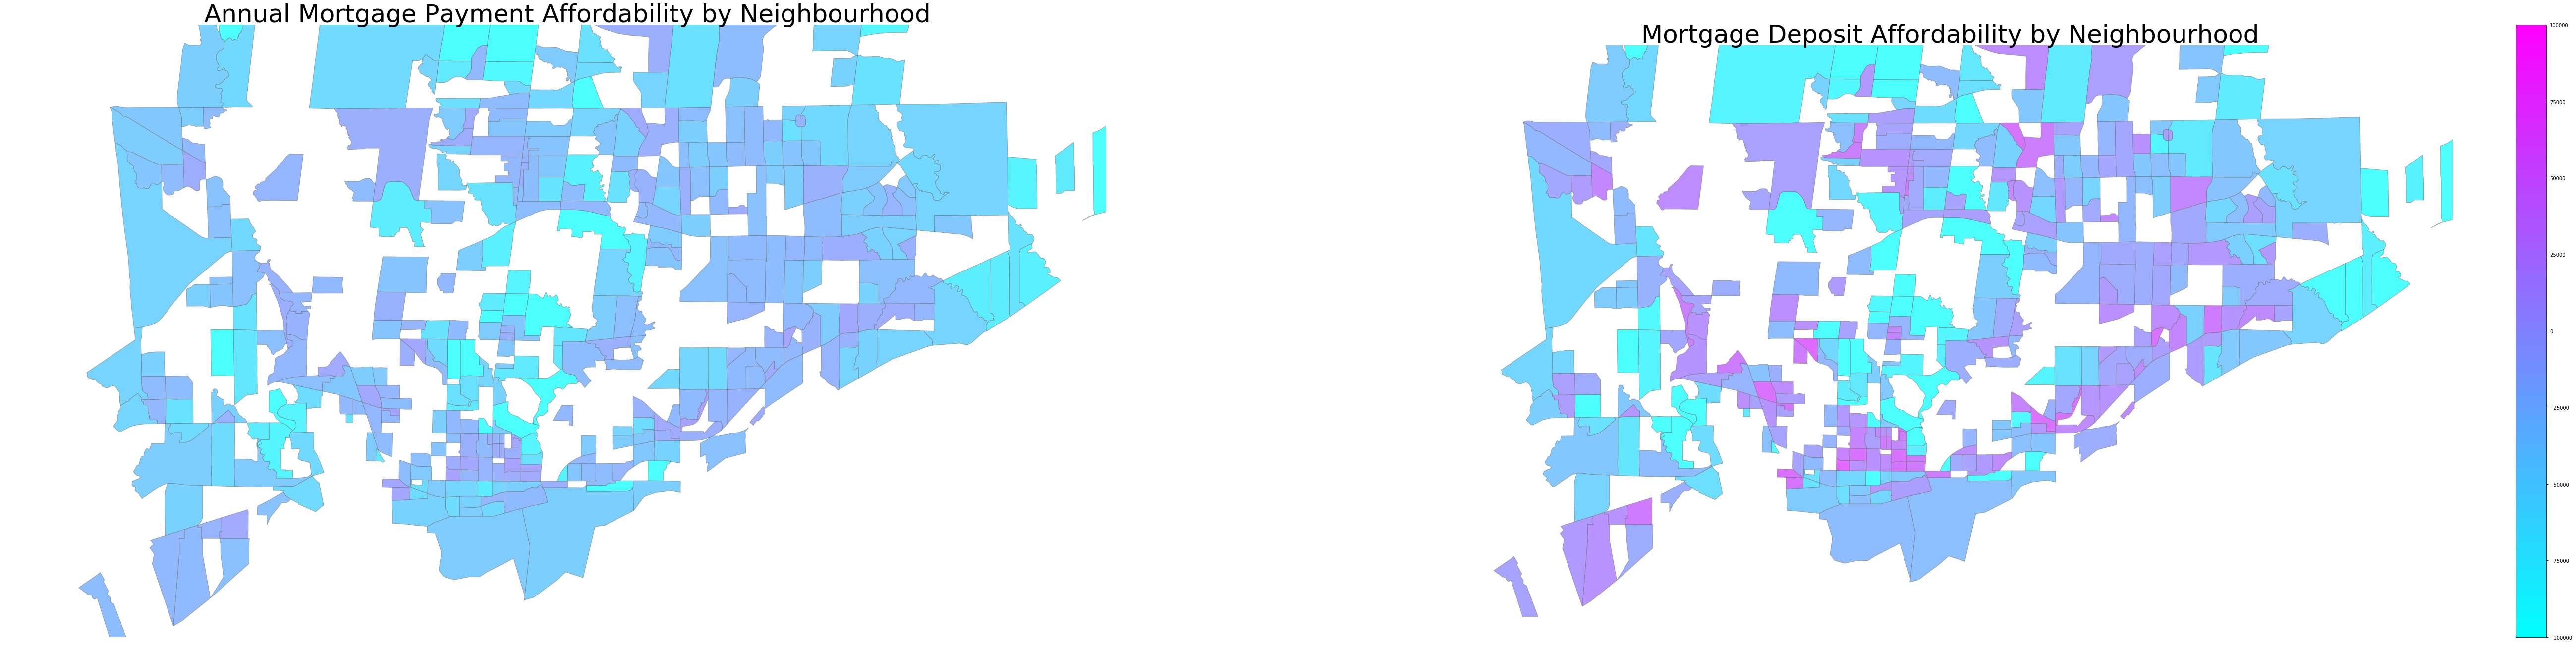

In [31]:
#Grid
gridsize = (2, 2)
fig = plt.figure(figsize=(100,50))
scale_min = np.min(-100000)
scale_max = np.max(100000)

#Set up axes 
ax1 = plt.subplot2grid(gridsize, (1, 0))
ax2 = plt.subplot2grid(gridsize, (1, 1), sharex=ax1, sharey=ax1)

#Plot 1
map_df2.plot(ax = ax1, vmin= scale_min, vmax = scale_max, column = 'affordability_mort',edgecolor = 'grey',alpha = 0.7,cmap='cool')
plt.xlim(xlim)
plt.ylim(ylim)
ax1.axis('off')
ax1.set_title('Annual Mortgage Payment Affordability by Neighbourhood',fontsize = 50)
#Plot 2
map_df2.plot(ax = ax2, vmin= scale_min, vmax = scale_max, column = 'affordability_dep',edgecolor = 'grey',alpha = 0.7,cmap='cool',legend=True)
plt.xlim(xlim)
plt.ylim(ylim)
ax2.axis('off')
ax2.set_title('Mortgage Deposit Affordability by Neighbourhood',fontsize = 50)
                       

# Score of Local Housing based on Median Household Income

Based on our scoring criteria, it seems that the downtown core scored pretty well in terms of affordability for the size of property, with affordabolity scores dropping as we move to the surrounding neighbourhoods. This drop in score could largely be based on the increase in price between houses and condo units. Because the score is largely dependent on the calculated affordability based on neighbourhood household income, the scoring would be largely localized by neighbourhood.

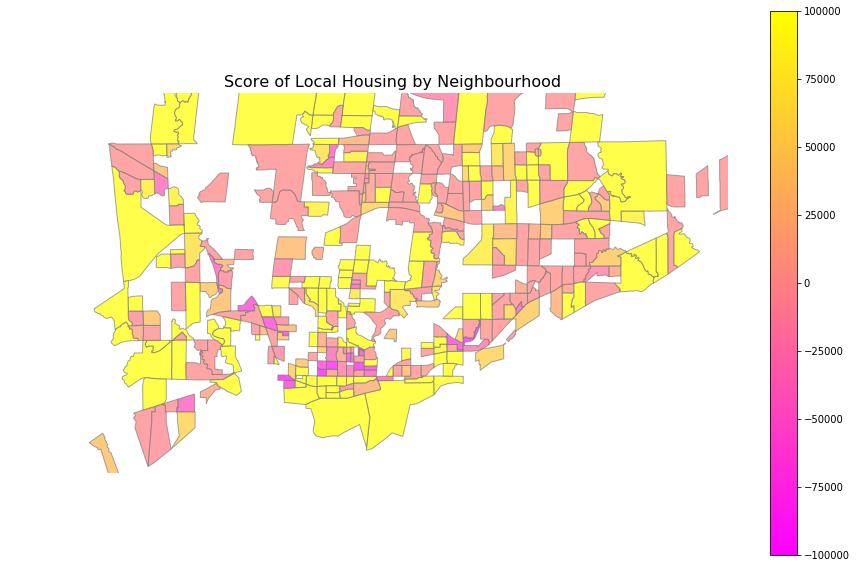

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
map_df2.plot(ax=ax, vmin= -100000, vmax = 100000, column = 'score',edgecolor = 'grey',alpha = 0.7,cmap='spring',legend=True)
#sns.scatterplot("longitude", "latitude", data=gdf,edgecolor = None ,alpha = 0.5)
plt.xlim(xlim)
plt.ylim(ylim)
plt.title('Score of Local Housing by Neighbourhood',fontsize=16)
ax.axis('off')
plt.show()

# Playground